## Airplane Crash Investigation

### Table of Contents
* [Import Dataset](#import_data)
* [Data Preprocessing](#preprocessing)
    * [Initial Check](#initial_check)
    * [Remove NaN Values](#remove_null)
    * [Feature Engineering](#f_e)
* [EDA](#eda)
    * [What day and time is more likely for accidents to happen?](#q1)
    * [Military Airplanes vs. Non Military Airplanes](#q2)
    * [Summary Analysis](#q3)
* [Modeling](#M)

### Import Dataset <a class='anchor' id = 'import_data'></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bioinfokit.visuz import cluster

ModuleNotFoundError: No module named 'bioinfokit'

In [2]:
df = pd.read_csv('./data/crash.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


### Data Preprocessing  <a class='anchor' id = 'preprocessing'></a>

#### Initial Check <a class='anchor' id = 'initial_check'></a>

In [3]:
df.shape

(5268, 13)

In [4]:
df.dtypes

Date             object
Time             object
Location         object
Operator         object
Flight #         object
Route            object
Type             object
Registration     object
cn/In            object
Aboard          float64
Fatalities      float64
Ground          float64
Summary          object
dtype: object

In [5]:
df.isnull().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64

In [6]:
df.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


#### Remove NaN Values <a class='anchor' id = 'remove_null'></a>

In [7]:
# Since there are only 5268 rows of data and the max of the Ground kill is 2750,
# I'm going to set the null values for Aboard, Ground and Fatalities column to it's mean.

df['Aboard'].fillna(df['Aboard'].mean(), inplace = True)
df['Ground'].fillna(df['Ground'].mean(), inplace = True)
df['Fatalities'].fillna(df['Fatalities'].mean(), inplace = True)

In [8]:
df['Summary'].fillna('No summary', inplace = True)
df['Time'].fillna(25, inplace = True)
df['Location'].fillna('Unknown', inplace = True)
df['Type'].fillna('Unknown', inplace = True)
df['Route'].fillna('Unknown', inplace = True)
df['Operator'].fillna('Unknown', inplace = True)

In [9]:
# Flight number, ICAO registration and Construction/serial number should not impact
# the reasons of the crashes, so I decided to delete those columns. 
df.drop(columns=['Flight #', 'Registration','cn/In'], inplace = True)

In [10]:
df.isnull().sum()

Date          0
Time          0
Location      0
Operator      0
Route         0
Type          0
Aboard        0
Fatalities    0
Ground        0
Summary       0
dtype: int64

#### Feature Engineering <a class='anchor' id = 'f_e'></a>

In [11]:
df['Survivors'] = df['Aboard'] - df['Fatalities']

In [12]:
for i in df['Time']:
    try:
        pd.to_datetime(i)
    except:
        print(i)

c: 1:00
c:17:00
c: 2:00
c:09:00
c16:50
12'20
18.40
c:09:00
114:20
c14:30
0943
22'08
c: 9:40


In [13]:
df['Time'] = df['Time'].replace({'0943':'09:43','114:20': '14:20'})
df['Time'] = df['Time'].astype('str')

hr = []
for i in df['Time']:
    hr.append(format(int(re.findall('\d+', i)[0]), '02'))

df['hr'] = hr

In [14]:
df.head()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary,Survivors,hr
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",1.0,17
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,0.0,06
2,08/06/1913,25,"Victoria, British Columbia, Canada",Private,Unknown,Curtiss seaplane,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,0.0,25
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,Unknown,Zeppelin L-1 (airship),20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,6.0,18
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,Unknown,Zeppelin L-2 (airship),30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,0.0,10


### EDA<a class='anchor' id = 'eda'></a>

#### What day and time is more likely for accidents to happen? <a class='anchor' id = 'q1'></a>

In [15]:
hour_df = pd.DataFrame(df.groupby(by = ['hr']).count().sort_values(by= 'hr')['Operator'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


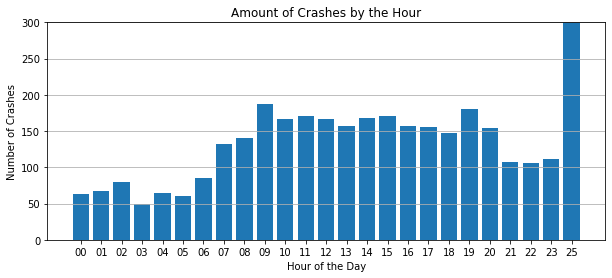

In [16]:
plt.figure(figsize = (10,4))
plt.bar(hour_df.index, hour_df['Operator'] )
plt.axes().yaxis.grid()
plt.ylim([0, 300])
plt.title('Amount of Crashes by the Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes');

In [17]:
# Create a copy of the df as df_day 
df_day = df.copy()

# Change the Date column to be date type 
df_day['Date'] = pd.to_datetime(df_day['Date'])

# Set df_day's index to be the date
df_day.set_index('Date', inplace = True)
df_day.sort_index(inplace = True)

In [18]:
df_day.resample('M').count()['Operator'][:5]

Date
1908-09-30    1
1908-10-31    0
1908-11-30    0
1908-12-31    0
1909-01-31    0
Freq: M, Name: Operator, dtype: int64

#### Military Airplanes vs. Non Military Airplanes? <a class='anchor' id='q2'></a>

In [19]:
df['military'] = df['Operator'].apply(lambda x: 'Military Airplanes' if 'Military' in x else 'Non Military Airplanes')

In [20]:
count_mil = pd.DataFrame(df['military'].value_counts())
count_mil

,military
Non Military Airplanes,4487
Military Airplanes,781


<BarContainer object of 2 artists>

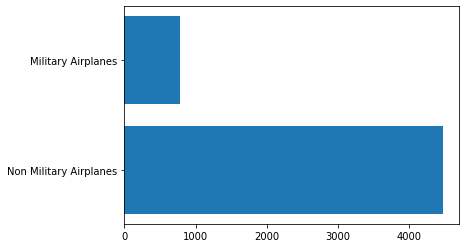

In [21]:
plt.barh(count_mil.index,count_mil['military'])


In [22]:
survivor_mil = pd.DataFrame(df.groupby(df['military']).sum()[['Survivors', 'Aboard']])
survivor_mil['SurviveRate'] = survivor_mil['Survivors']/ survivor_mil['Aboard']
survivor_mil

,Survivors,Aboard,SurviveRate
military,,,
Military Airplanes,1801.972430,21505.109035,0.083793
Non Military Airplanes,37635.407326,123652.090355,0.304365


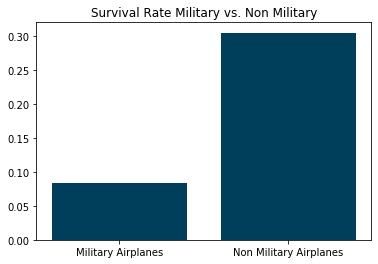

In [23]:
plt.bar(survivor_mil.index,survivor_mil['SurviveRate'], color = '#003f5c')
plt.title('Survival Rate Military vs. Non Military');

#### Summary Analysis <a class='anchor' id='q3'></a>
* What are the most frequent words appeared in the summary

In [24]:
# Make a function to clean the Summary filed
def clean_summary(summary):
    # Remove all the non-letters characters
    letters_only = re.sub("[^a-zA-Z]", " ", summary)
    
    # Conver all letters to lowercase 
    lower = letters_only.lower().split()
    
    # Set and remove addition stop words 
    stop = ['summary', 'airplane', 'aircraft', 'plane', 'flight', 'en']
    words = [word for word in lower if word not in stop]
    
    
    return (" ".join(words))


In [25]:
df['Summary'] = df['Summary'].map(lambda x: clean_summary(x))

In [26]:
cvec = CountVectorizer(stop_words='english')

In [27]:
df_summary = pd.DataFrame(cvec.fit_transform(df['Summary']).toarray(), columns = cvec.get_feature_names())
df_summary.head()

,aad,aaliyah,ababa,abandon,abandoned,abandoning,abandonment,abatement,abbas,abbreviation,...,zimathan,zimbabwe,zk,zlat,zone,zones,zue,zulia,zuma,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
top_words = {}
for i in df_summary.columns:
    top_words[i] = df_summary[i].sum()
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))[:20]

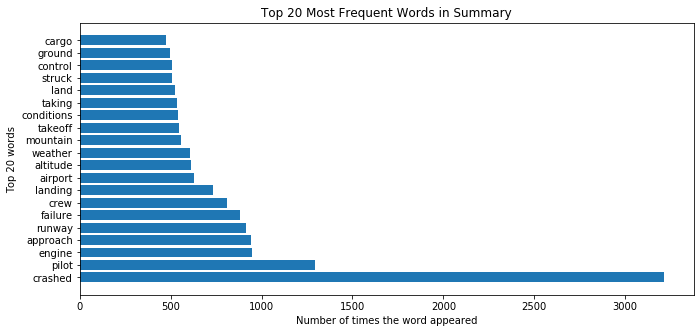

In [29]:
plt.figure(figsize=[11, 5])
plt.barh(most_freq[0], most_freq[1])
plt.title('Top 20 Most Frequent Words in Summary')
plt.xlabel('Number of times the word appeared')
plt.ylabel('Top 20 words');

* Sentiment Analysis with VADER

In [30]:
sia = SentimentIntensityAnalyzer()

In [31]:
dicts = []
for each in df['Summary']:
    scores = sia.polarity_scores(each)
    dicts.append(scores)
scores = pd.DataFrame(dicts)
sent_df = pd.concat([df, scores], axis =1)

In [32]:
sent_df.head(2)

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary,Survivors,hr,military,neg,neu,pos,compound
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,0.0,during a demonstration a u s army flyer flown ...,1.0,17,Military Airplanes,0.32,0.664,0.015,-0.9818
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5.0,0.0,first u s dirigible akron exploded just offsho...,0.0,06,Military Airplanes,0.00,1.000,0.000,0.0000


<Figure size 720x504 with 0 Axes>

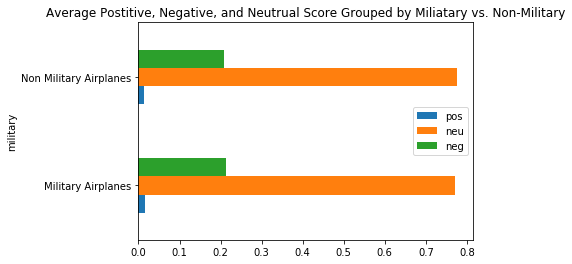

In [33]:
# Visualizing sentiments
plt.figure(figsize= [10,7])
sent_df.groupby('military').mean()[['pos', 'neu','neg']].plot(kind='barh')
plt.title('Average Postitive, Negative, and Neutrual Score Grouped by Miliatary vs. Non-Military');

### Modeling <a class='modeling' id='M'></a>
Use clustering algorithms to partition the summary data in order to analyze and understand the reasons of why airplanes crash

#### KMeans
* Use inertia score and silhouette score to find the best K

In [34]:
df['year']= pd.DatetimeIndex(df['Date']).year

In [35]:
df['hr'] = df['hr'].astype('int64')

In [36]:
X = df[['Aboard','year', 'Fatalities', 'Ground', 'hr']]

In [37]:
# Since K-Means is highley scale dependent and not suitable for different densities, 
# we need to normalize the dataset before fit the model
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [38]:
scores = []
for k in range (2, 30):
    cl = KMeans(n_clusters = k,random_state = 42)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])

score_df = pd.DataFrame(scores)
score_df.columns = ['k','inertia','silhouette']

In [53]:
score_df.head(13)

,k,inertia,silhouette
0,2,20311.949121,0.546795
1,3,15121.954988,0.532841
2,4,10809.943358,0.343961
3,5,8656.877596,0.331008
4,6,7380.224012,0.341031
5,7,6199.185943,0.357462
6,8,5479.480869,0.366779
7,9,4937.243002,0.369116
8,10,4555.145989,0.312647
9,11,4235.813063,0.319015


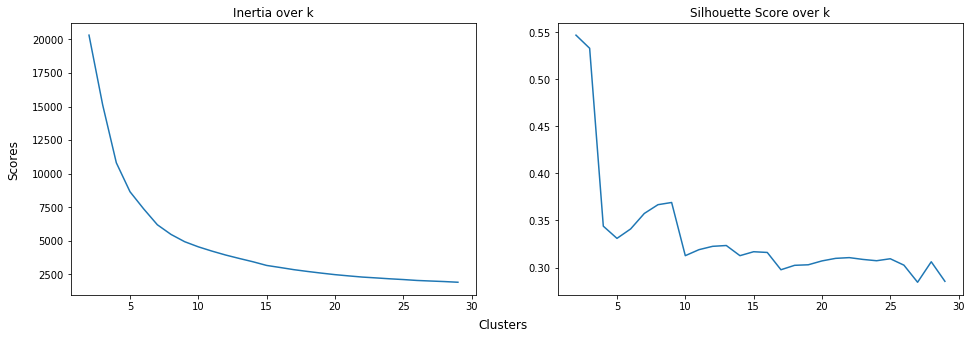

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')
fig.text(0.5, 0.03, 'Clusters', ha='center', size = 'large')
fig.text(0.07, 0.5,'Scores', va='center', rotation = 'vertical', size = 'large');

Inertia measures the sum of squared errors, as cluster increases the inertia score keeps decreassing. However, when k = 9, we can see that it is the elbow of the inertia plot and it also has a pretty high silhouette score. This means that at k =9, the clusters have the lowest cohesion inside each cluster and highest separation between different clusters. So I chose to use 10 clusters for modeling.  

In [67]:
km = KMeans(n_clusters = 9, random_state = 42)
km.fit(X_sc)

KMeans(n_clusters=9, random_state=42)

In [55]:
df['cluster'] = km.labels_
df.head(2)

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary,Survivors,hr,military,year,cluster
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,0.0,during a demonstration a u s army flyer flown ...,1.0,17,Military Airplanes,1908,3
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5.0,0.0,first u s dirigible akron exploded just offsho...,0.0,6,Military Airplanes,1912,0


In [56]:
df.groupby('cluster').mean()

,Aboard,Fatalities,Ground,Survivors,hr,year
cluster,,,,,,
0,20.619824,15.900878,0.806285,4.718946,8.534504,1957.070263
1,133.409091,125.488636,1.005682,7.920455,13.136364,1984.460227
2,78.500000,78.500000,2750.000000,0.000000,8.500000,2001.000000
3,13.317896,10.570001,0.167027,2.747895,24.234510,1943.940392
4,202.265823,12.075949,0.189873,190.189873,15.569620,1988.101266
5,287.392857,274.857143,0.642857,12.535714,14.535714,1989.000000
6,66.911883,54.106754,0.869281,12.805130,18.139434,1976.137255
7,14.360879,10.345675,0.393591,4.015204,23.279372,1982.377049
8,12.492915,8.801619,0.945960,3.691296,10.691296,1995.177126


In [57]:
total_amount = df.groupby('cluster').count()['Type']
total_fatalities = df.groupby('cluster').sum()['Fatalities']
total_survivors =  df.groupby('cluster').sum()['Survivors']
sum_df = pd.DataFrame({'total_crushes': total_amount, 'total_fatalities': total_fatalities, 'total_survivors': total_survivors})

In [83]:
sum_df= sum_df.reset_index()

In [85]:
sum_df.head()

,cluster,total_crushes,total_fatalities,total_survivors
0,0,797,12673.000000,3761.000000
1,1,176,22086.000000,1394.000000
2,2,2,157.000000,0.000000
3,3,1275,13476.751332,3503.566434
4,4,79,954.000000,15025.000000


#### PCA 
* use PCA to visualize the clusters

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components = 2, random_state = 42)
pc = pca.fit_transform(X_sc)

In [64]:
km_pca = KMeans(n_clusters = 9, random_state = 42)

In [65]:
km_pca.fit(pc)

KMeans(n_clusters=9, random_state=42)

In [66]:
silhouette_score(pc, km_pca.labels_)

0.3983054066406605

In [71]:
pca_df = pd.DataFrame(pc, columns=['pc1', 'pc2'])
pca_df['cluster'] = km_pca.labels_

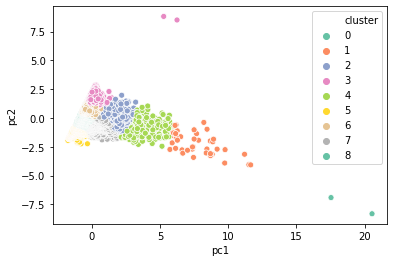

In [80]:
sns.scatterplot(pca_df['pc1'], pca_df['pc2'],hue=pca_df['cluster'], palette='Set2')